<a href="https://colab.research.google.com/github/shubhamtheds/Automated-Trading-Systems-using-ML/blob/main/nifty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import warnings
warnings.filterwarnings('ignore')

In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, precision_score

In [11]:
class StockPredictor:

    def __init__(self, symbol, start=None, end=None):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.data = None
        self.model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
        self.predictors = []

    def load_data(self):
        stock = yf.Ticker(self.symbol)
        self.data = stock.history(period="max")
        self.data.index = pd.to_datetime(self.data.index)
        self.data = self.data.loc["2000-01-01":].copy()
        del self.data["Dividends"]
        del self.data["Stock Splits"]

    def preprocess_data(self):
        self.data["Tomorrow"] = self.data["Close"].shift(-1)
        self.data["Target"] = (self.data["Tomorrow"] > self.data["Close"]).astype(int)

        horizons = [2, 5, 60, 250, 1000]

        for horizon in horizons:
            rolling_averages = self.data.rolling(horizon).mean()

            ratio_column = f"Close_Ratio_{horizon}"
            self.data[ratio_column] = self.data["Close"] / rolling_averages["Close"]

            trend_column = f"Trend_{horizon}"
            self.data[trend_column] = self.data.shift(1).rolling(horizon).sum()["Target"]

            self.predictors += [ratio_column, trend_column]

        self.data = self.data.dropna(subset=self.data.columns[self.data.columns != "Tomorrow"])

    def predict(self, train, test):
        self.model.fit(train[self.predictors], train["Target"])
        test_with_returns = test.copy()
        test_with_returns["Returns"] = test_with_returns["Close"].pct_change()
        preds = self.model.predict_proba(test_with_returns[self.predictors])[:, 1]
        preds[preds >= 0.6] = 1
        preds[preds < 0.6] = 0
        preds = pd.Series(preds, index=test_with_returns.index, name="Predictions")
        test_with_returns["Predictions"] = preds
        test_with_returns["Strategy_Returns"] = test_with_returns["Predictions"] * test_with_returns["Returns"]
        combined = pd.concat([test_with_returns["Target"], test_with_returns["Predictions"], test_with_returns["Returns"], test_with_returns["Strategy_Returns"]], axis=1)
        return combined

    def backtest(self, start=2500, step=250):
        all_predictions = []

        for i in range(start, self.data.shape[0], step):
            train = self.data.iloc[0:i].copy()
            test = self.data.iloc[i:(i + step)].copy()
            predictions = self.predict(train, test)
            all_predictions.append(predictions)

        return pd.concat(all_predictions)

    def evaluate(self, predictions):
        return precision_score(predictions["Target"], predictions["Predictions"])

    def plot_results(self):
        all_predictions = self.backtest()
        all_predictions["Buy_And_Hold_Returns"] = all_predictions["Returns"].cumsum()
        all_predictions["Strategy_Returns"] = all_predictions["Strategy_Returns"].cumsum()

        precision = self.evaluate(all_predictions)

        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(all_predictions["Buy_And_Hold_Returns"], label="Buy and Hold Returns")
        ax.plot(all_predictions["Strategy_Returns"], label="Strategy Returns")
        ax.set_title(f"{self.symbol} Buy and Hold vs. Strategy Returns (Precision={precision:.3f})")
        ax.set_xlabel("Time")
        ax.set_ylabel("Returns")
        ax.legend()

        plt.show()

    def run(self):
        self.load_data()
        self.preprocess_data()
        self.plot_results()

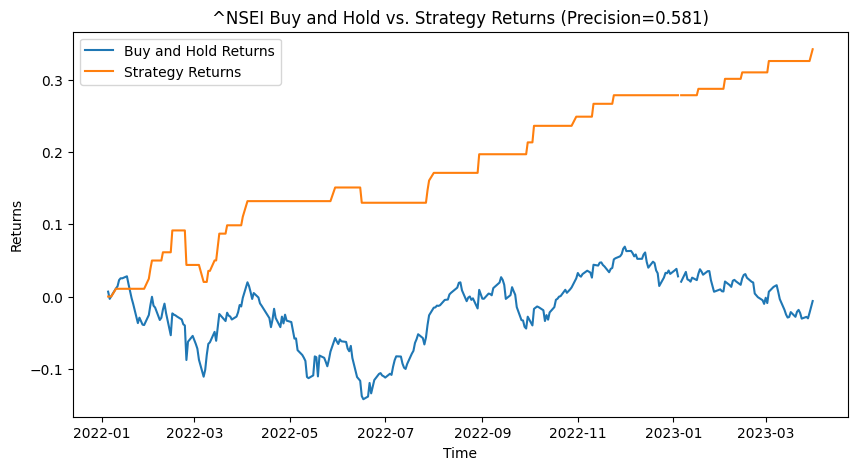

In [12]:
nifty_predictor = StockPredictor("^NSEI")
nifty_predictor.run()

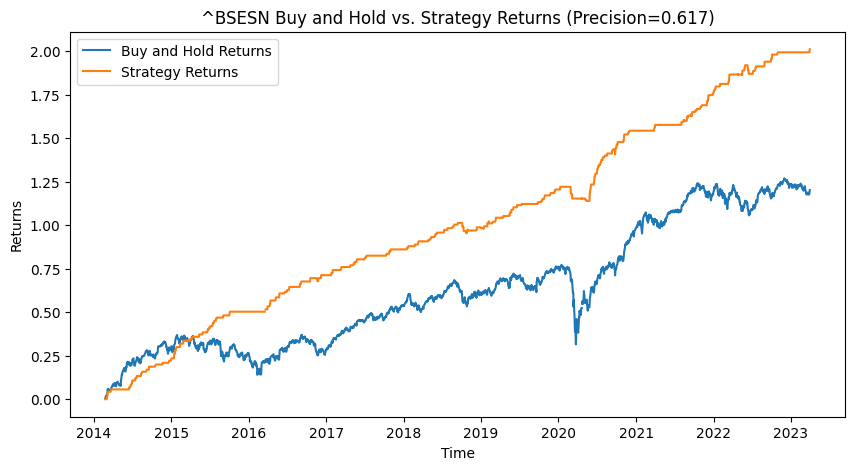

In [13]:
sensex_predictor = StockPredictor("^BSESN")
sensex_predictor.run()